In [1]:
import sys; sys.path.insert(0, "../../")

from src.dun.utils import set_all_seeds_torch, gen_simple_1d
from src.dun.dun import DUN, ProductDUN
from src.dun.base_models import MLP

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, Categorical

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

In [2]:
print(torch.cuda.is_available(), torch.cuda.device_count())

True 1


In [13]:
set_all_seeds_torch(0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [5]:
X_train, y_train, X_test, y_test = gen_simple_1d()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_dataloader = DataLoader(train_data, batch_size=501, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=501, shuffle=True)

(501, 1)
(501, 1)
(501, 1)
(501, 1)


## 1) DUN

In [8]:
width = 100
depth = 5
net = MLP(1, width, 1, depth)
print(f"Nr. params: {sum(p.numel() for p in net.parameters())}")
model = DUN(net).to(device)

lr = 1e-3
momentum = 0.9
wd = 1e-4
epochs = 501
print_fit_every = 100
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd)

Nr. params: 51801


  0%|          | 0/501 [00:00<?, ?it/s]

/tmp/ipykernel_16268/1817300346.py:42: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  xs = torch.range(-3, 3, step=0.01)


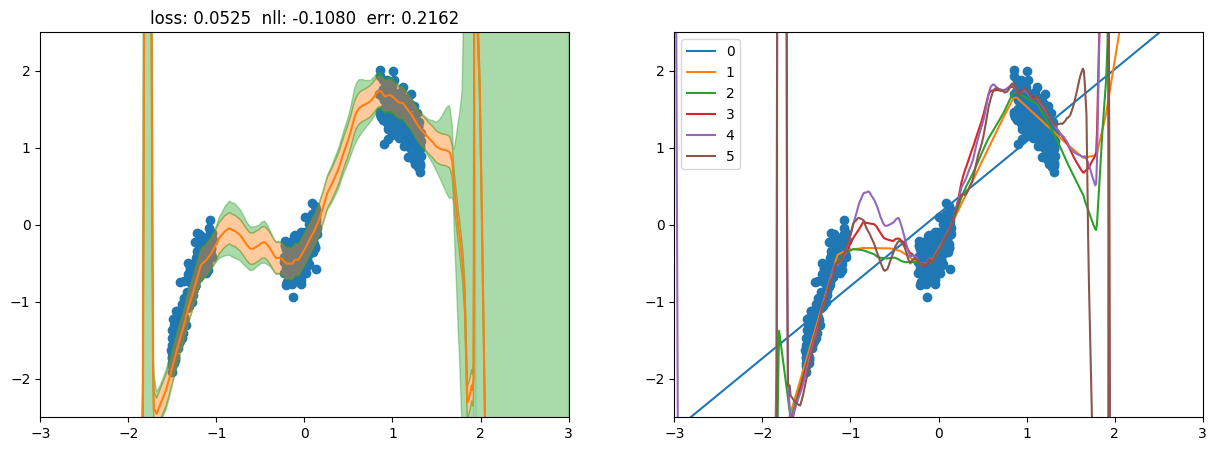

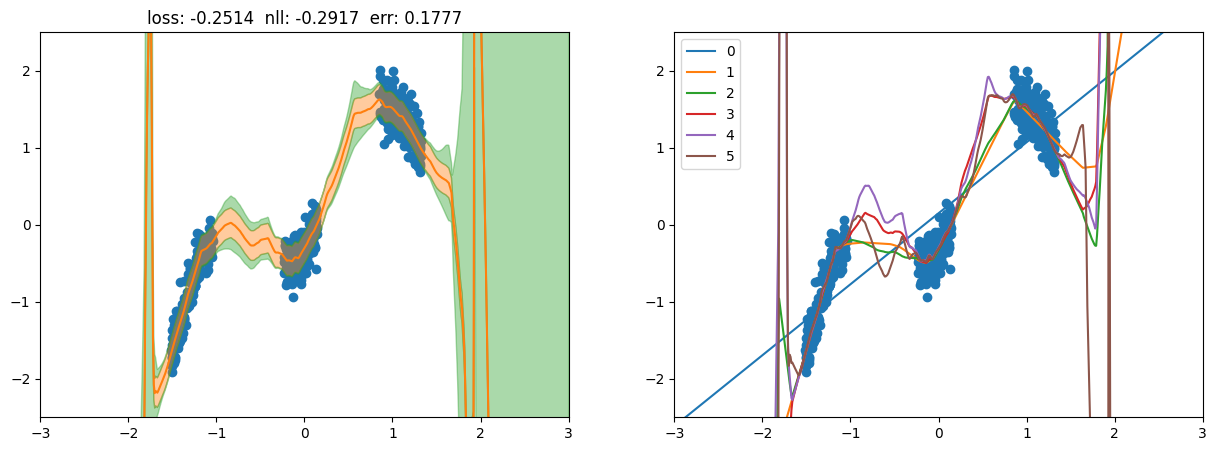

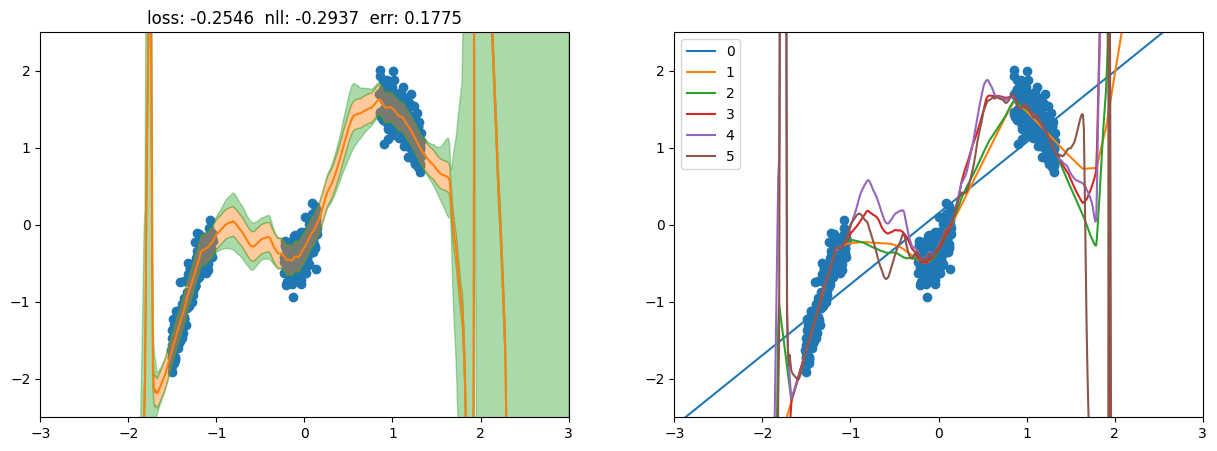

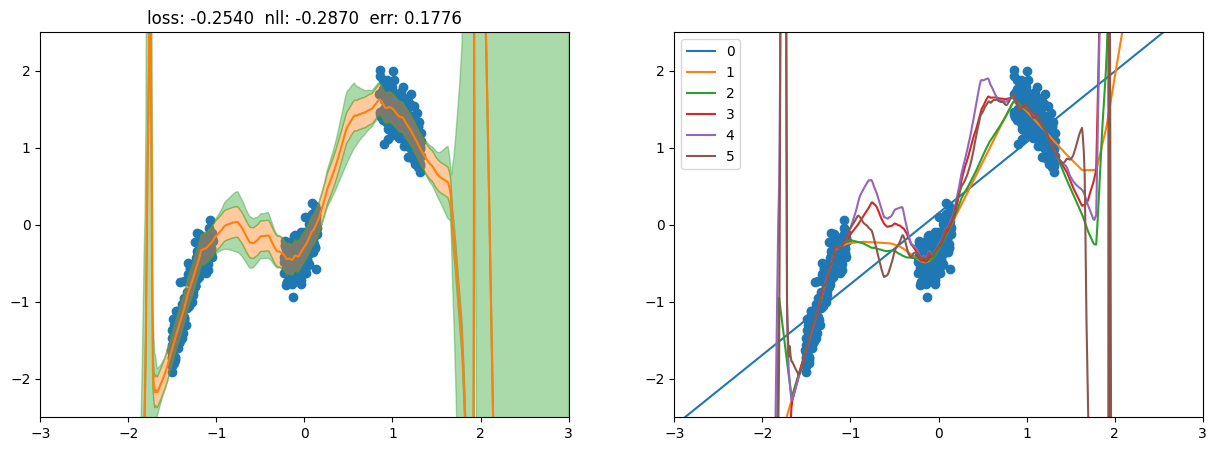

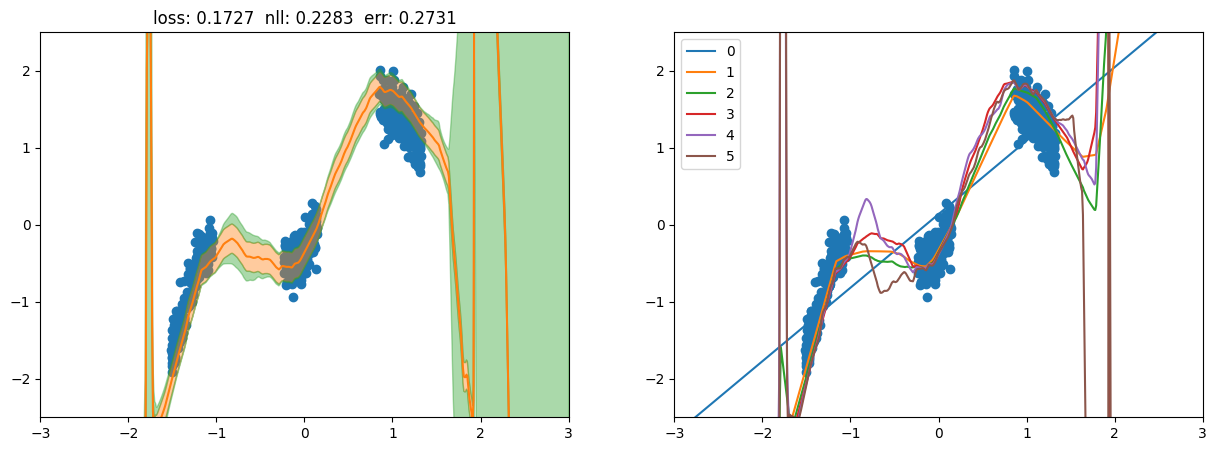

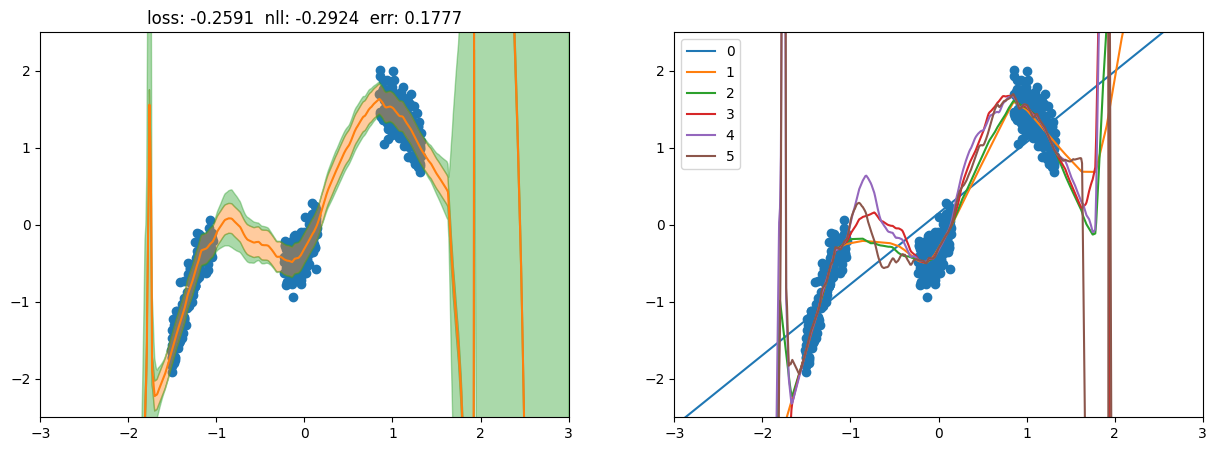

In [17]:
trange = tqdm(range(epochs))
for epoch in trange:
    loss = 0
    err = 0
    nll = 0
    N = len(X_train)

    model.train()
    for x, y in train_dataloader:
        optim.zero_grad()
        x, y = x.to(device), y.to(device)

        elbo = model.ELBO(x, y, N)
        b_loss = -elbo / N

        b_loss.backward()
        optim.step()

        preds = model.net(x)
        probs = F.softmax(model.q_logits, dim=0).view(-1, 1, 1)

        μ = torch.sum(preds * probs, dim=0)
        σ2_m = torch.sum(preds**2 * probs, dim=0) - μ**2
        σ2_d = torch.exp(model.logσ * 2)
        σ2 = σ2_m + σ2_d

        likelihood = Normal(μ, σ2 ** 0.5)
        b_nll = -likelihood.log_prob(y).mean(dim=0).item()
        b_err = ((μ - y)**2).mean(dim=0).pow(0.5).item()

        err += b_err * x.shape[0]
        nll += b_nll * x.shape[0]
        loss += b_loss * x.shape[0]

    loss /= N
    err /= N
    nll /= N

    if epoch % print_fit_every == 0 or epoch == 0:
        model.eval()
        # print(F.softmax(model.q_logits, dim=0).view(-1, 1, 1) )
        xs = torch.range(-3, 3, step=0.01)
        μs, σ2s, σ2_d, preds = model(xs.view(-1, 1).to(device), return_depth_preds=True)

        xs = xs.numpy()
        μs = μs.cpu().detach().numpy()[:, 0]
        σs = (σ2s.cpu().detach().numpy() ** 0.5)[:, 0]
        σ_d = σ2_d.cpu().detach().numpy() ** 0.5
        preds = preds.cpu().detach().numpy()[:, :, 0]
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].scatter(X_train, y_train, c='C0')
        ax[1].scatter(X_train, y_train, c='C0')
        for i in range(depth + 1):
            ax[1].plot(xs, preds[i], label=i)
        ax[0].plot(xs, μs, c='C1')
        ax[0].fill_between(xs, μs - σ_d, μs + σ_d, color='C1', alpha=0.4)
        ax[0].fill_between(xs, μs - σ_d, μs - σs, color='C2', alpha=0.4)
        ax[0].fill_between(xs, μs + σ_d, μs + σs, color='C2', alpha=0.4)
        ax[0].set_title(f"loss: {loss:.4f}  nll: {nll:.4f}  err: {err:.4f}")
        ax[0].set_ylim(-2.5, 2.5)
        ax[0].set_xlim(-3., 3.)
        ax[1].set_ylim(-2.5, 2.5)
        ax[1].set_xlim(-3., 3.)
        ax[1].legend()

        plt.show()
        
    trange.set_postfix({"loss": loss, "nll": nll, "err": err})

## 2) ProductDUN

In [14]:
width = 100
depth = 5
net = MLP(1, width, 1, depth)
print(f"Nr. params: {sum(p.numel() for p in net.parameters())}")
model = ProductDUN(net).to(device)

lr = 1e-3
momentum = 0.9
wd = 1e-4
epochs = 501
print_fit_every = 100
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd)

Nr. params: 51801


  0%|          | 0/501 [00:00<?, ?it/s]

/tmp/ipykernel_24054/1717254748.py:38: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  xs = torch.range(-3, 3, step=0.01)


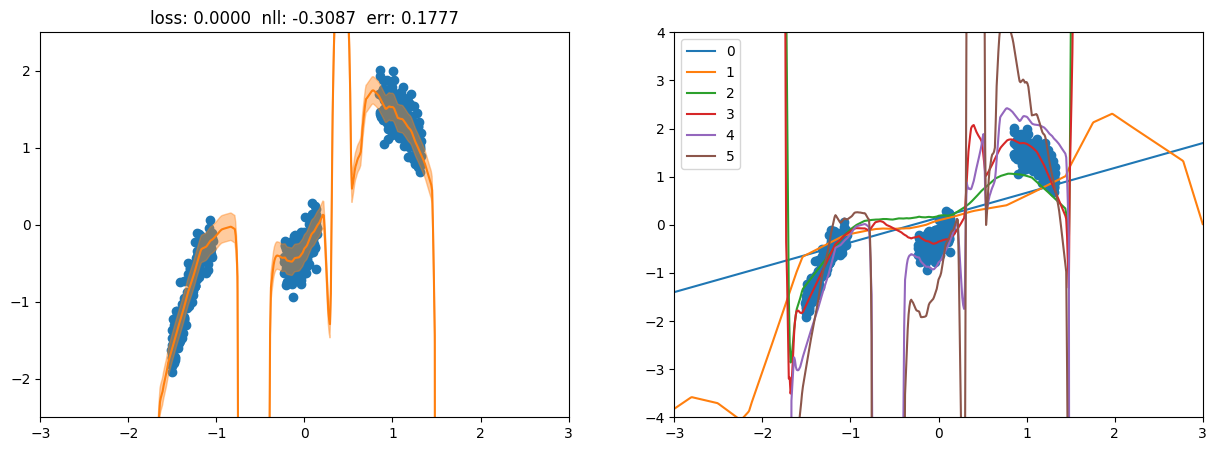

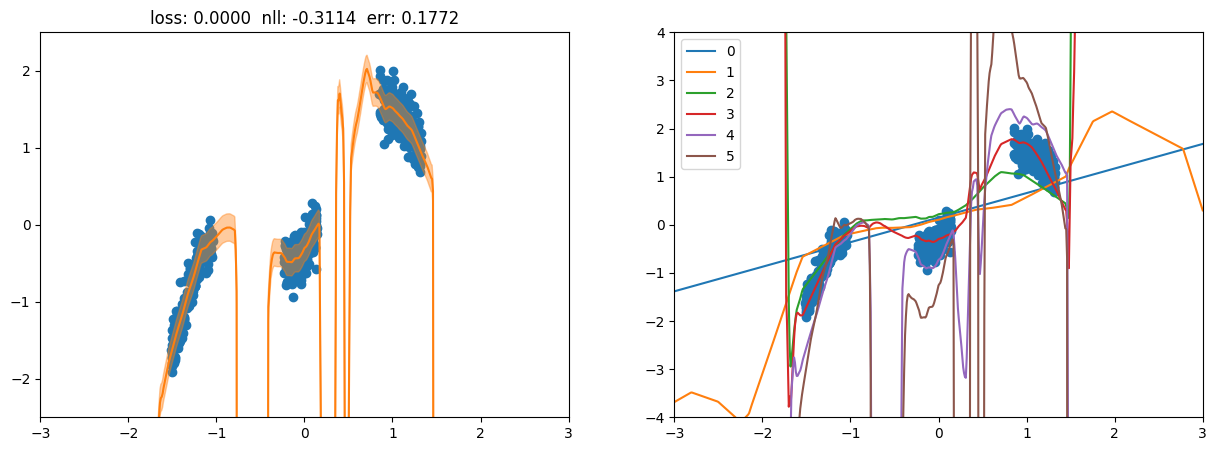

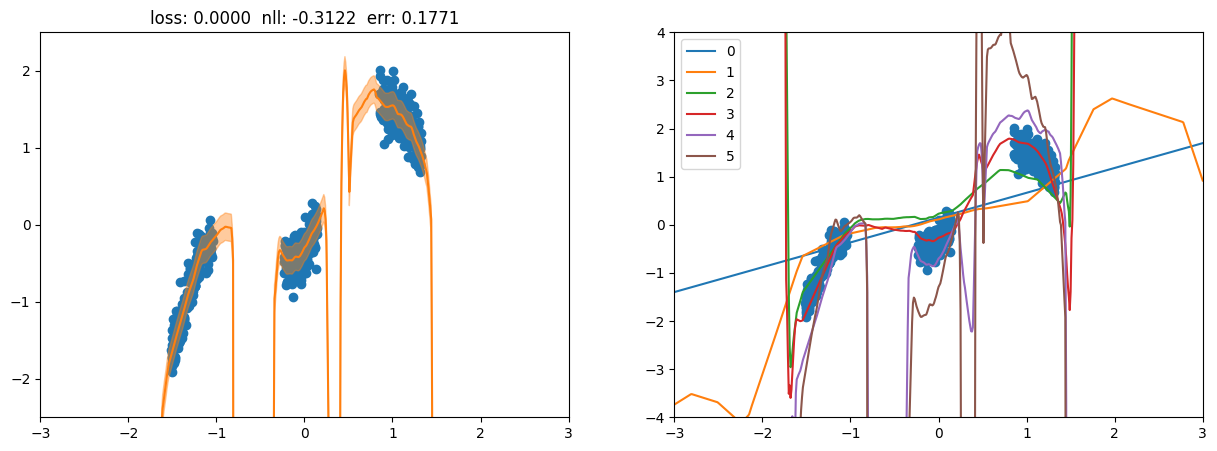

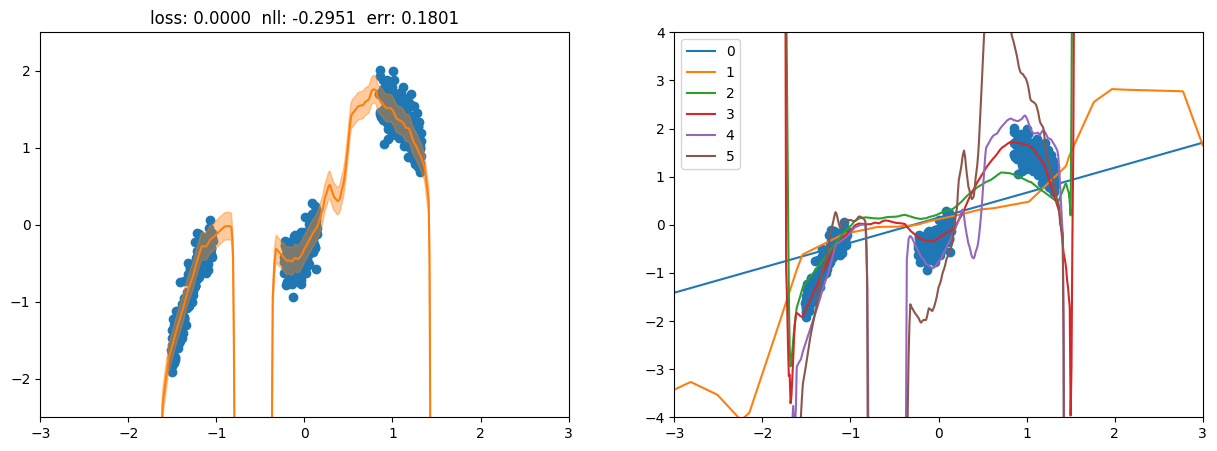

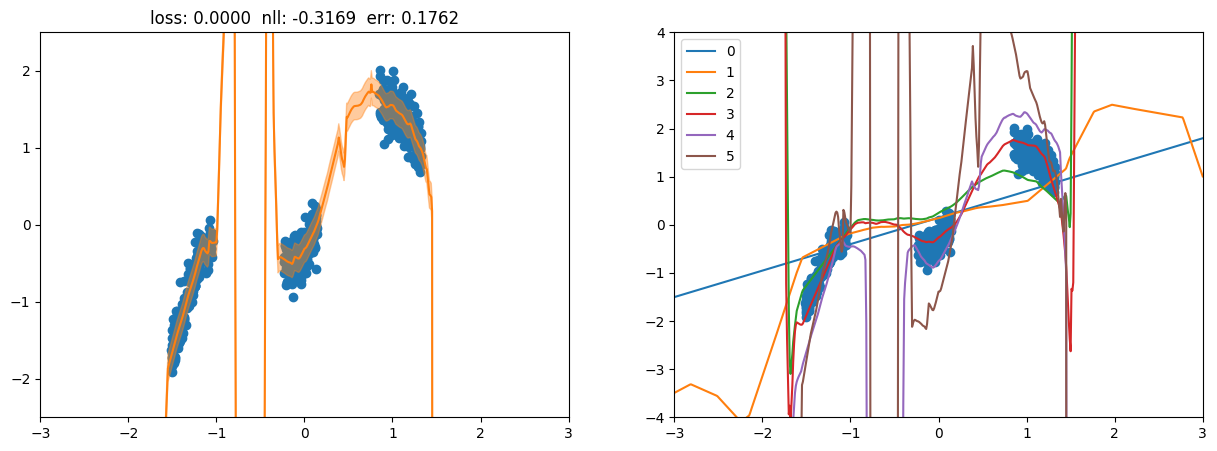

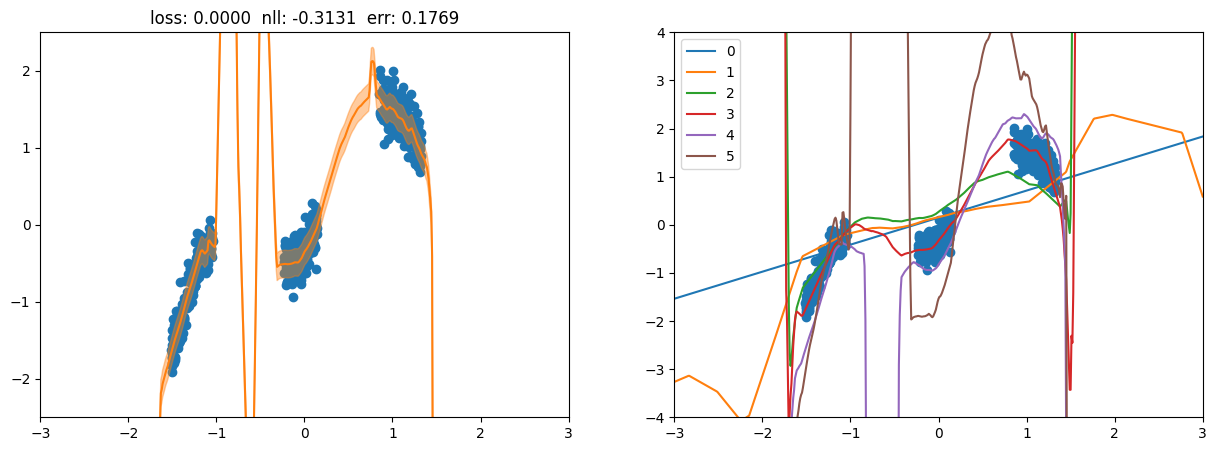

In [16]:
trange = tqdm(range(epochs))
for epoch in trange:
    loss = 0
    err = 0
    nll = 0
    N = len(X_train)

    model.train()
    for x, y in train_dataloader:
        optim.zero_grad()
        x, y = x.to(device), y.to(device)

        loss = model.product_loss(x, y, N)
        b_loss = -loss / N

        b_loss.backward()
        optim.step()

        preds = model.net(x)
        probs = F.softmax(model.ens_weights, dim=0).view(-1, 1, 1)
        
        μ, σ2 = model(x)

        likelihood = Normal(μ, σ2 ** 0.5)
        b_nll = -likelihood.log_prob(y).mean(dim=0).item()
        b_err = ((μ - y)**2).mean(dim=0).pow(0.5).item()

        err += b_err * x.shape[0]
        nll += b_nll * x.shape[0]
        loss += b_loss * x.shape[0]

    loss /= N
    err /= N
    nll /= N

    if epoch % print_fit_every == 0 or epoch == 0:
        model.eval()
        xs = torch.range(-3, 3, step=0.01)
        μs, σ2s, preds = model(xs.view(-1, 1).to(device), return_depth_preds=True)

        xs = xs.numpy()
        μs = μs.cpu().detach().numpy()[:, 0]
        σs = (σ2s.cpu().detach().numpy() ** 0.5)
        # σ_d = σ2_d.cpu().detach().numpy() ** 0.5
        preds = preds.cpu().detach().numpy()[:, :, 0]
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].scatter(X_train, y_train, c='C0')
        ax[1].scatter(X_train, y_train, c='C0')
        for i in range(depth + 1):
            ax[1].plot(xs, preds[i], label=i)
        ax[0].plot(xs, μs, c='C1')
        ax[0].fill_between(xs, μs - σs, μs + σs, color='C1', alpha=0.4)
#         ax[0].fill_between(xs, μs - σ_d, μs + σ_d, color='C1', alpha=0.4)
#         ax[0].fill_between(xs, μs - σ_d, μs - σs, color='C2', alpha=0.4)
#         ax[0].fill_between(xs, μs + σ_d, μs + σs, color='C2', alpha=0.4)
        ax[0].set_title(f"loss: {loss:.4f}  nll: {nll:.4f}  err: {err:.4f}")
        ax[0].set_ylim(-2.5, 2.5)
        ax[0].set_xlim(-3., 3.)
        ax[1].set_ylim(-4, 4)
        ax[1].set_xlim(-3., 3.)
        ax[1].legend()

        plt.show()
        
    trange.set_postfix({"loss": loss, "nll": nll, "err": err})